In [1]:
import keras
import keras.layers as layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import copy
from sklearn.metrics import brier_score_loss, roc_curve, auc, roc_auc_score, log_loss
from scipy.stats import entropy as scipy_entropy
from sklearn.model_selection import KFold
from sklearn.calibration import calibration_curve

2024-05-06 15:02:13.284615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 15:02:13.284714: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 15:02:13.386084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 1. Model 1
> Design and train a basic MNIST classifier, aiming for about 90% accuracy when trained on a small subset of the data.
### 1.1 Load Data

In [2]:
data = np.load('../input/mnist-data/mnist.npz')

x_train = data['x_train']
y_train = data['y_train']
x_test = data['x_test']
y_test = data['y_test']

# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_combined = np.concatenate((x_train, x_test), axis=0)
y_combined = np.concatenate((y_train, y_test), axis=0)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_combined, y_combined, test_size =0.95, random_state=6)

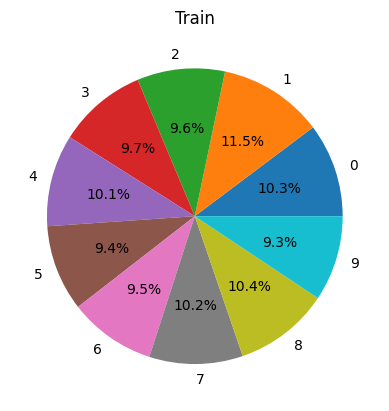

In [3]:
def plot_class_split(y, title):
    labels, counts = np.unique(y, return_counts=True)
    fig = plt.pie(counts, labels=labels, autopct='%1.1f%%')
    plt.title(title)
    return fig

fig = plot_class_split(y_train, 'Train')

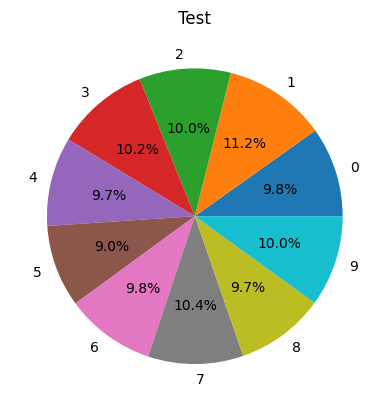

In [4]:
fig = plot_class_split(y_test, "Test")

In [5]:
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

x_train = preprocess(x_train)
x_test = preprocess(x_test)

### 1.2 Define and Train Model 

In [6]:
img_input = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(img_input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Dropout(0.5)(x)
x = layers.Flatten()(x)
x = layers.Dense(50, activation="relu")(x)
# for later
belly_model = keras.models.Model(img_input, x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(10, activation='softmax')(x)

model = keras.models.Model(img_input, x)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics = ['accuracy'])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │        78,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,528 (345.81 KB)

 Trainable params: 88,528 (345.81 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
checkpoint = ModelCheckpoint('/kaggle/working/best_model.keras', 
                    monitor="val_accuracy", mode="max", 
                    save_best_only=True, verbose=2)

history = model.fit(x_train, y_train, 
          epochs=5, batch_size=128, shuffle=True, 
          validation_data=(x_test,y_test), verbose = 2,
            callbacks=[checkpoint])

Epoch 1/5


2024-05-06 15:02:30.337967: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.00926, expected 1.33324
2024-05-06 15:02:30.338024: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 1.42382, expected 0.7478
2024-05-06 15:02:30.338044: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 1.50484, expected 0.828818
2024-05-06 15:02:30.338058: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.07018, expected 1.39416
2024-05-06 15:02:30.338069: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 1.44506, expected 0.769037
2024-05-06 15:02:30.338079: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.40969, expected 1.73366
2024-05-06 15:02:30.338091: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.8594, expected 2.18338
2024-05-06 15:02:30.338101: E external/local_xla/xla/se


Epoch 1: val_accuracy improved from -inf to 0.67029, saving model to /kaggle/working/best_model.keras
28/28 - 15s - 526ms/step - accuracy: 0.3160 - loss: 2.0075 - val_accuracy: 0.6703 - val_loss: 1.3698
Epoch 2/5

Epoch 2: val_accuracy improved from 0.67029 to 0.79150, saving model to /kaggle/working/best_model.keras
28/28 - 1s - 38ms/step - accuracy: 0.6017 - loss: 1.1924 - val_accuracy: 0.7915 - val_loss: 0.7034
Epoch 3/5

Epoch 3: val_accuracy improved from 0.79150 to 0.86878, saving model to /kaggle/working/best_model.keras
28/28 - 1s - 35ms/step - accuracy: 0.7214 - loss: 0.8422 - val_accuracy: 0.8688 - val_loss: 0.4952
Epoch 4/5

Epoch 4: val_accuracy improved from 0.86878 to 0.89248, saving model to /kaggle/working/best_model.keras
28/28 - 1s - 34ms/step - accuracy: 0.7851 - loss: 0.6493 - val_accuracy: 0.8925 - val_loss: 0.4002
Epoch 5/5

Epoch 5: val_accuracy improved from 0.89248 to 0.91526, saving model to /kaggle/working/best_model.keras
28/28 - 1s - 33ms/step - accuracy: 

### 1.3 Model Metrics

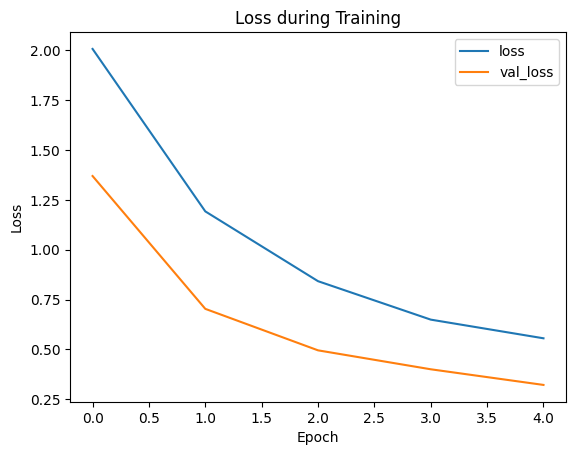

In [8]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")

plt.savefig("/kaggle/working/loss_over_time")

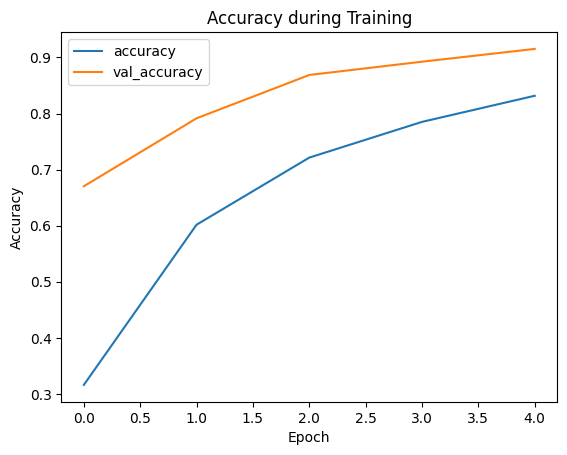

In [9]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy during Training")

plt.savefig("/kaggle/working/accuracy_over_time")

In [10]:
# generate confusion matrix with validation data
y_pred = model.predict(x_test)

# map predictions to integer encoding
y_pred = np.argmax(y_pred, axis=1)

2024-05-06 15:02:46.575065: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.67352, expected 0.857533
2024-05-06 15:02:46.575125: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 2.29495, expected 1.47897
2024-05-06 15:02:46.575134: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.22299, expected 1.40701
2024-05-06 15:02:46.575142: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 1.79493, expected 0.97894
2024-05-06 15:02:46.575150: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.27216, expected 1.45617
2024-05-06 15:02:46.575158: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 2.33952, expected 1.52354
2024-05-06 15:02:46.575166: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.27659, expected 1.4606
2024-05-06 15:02:46.575173: E external/local_xla/xla/se

2079/2079 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


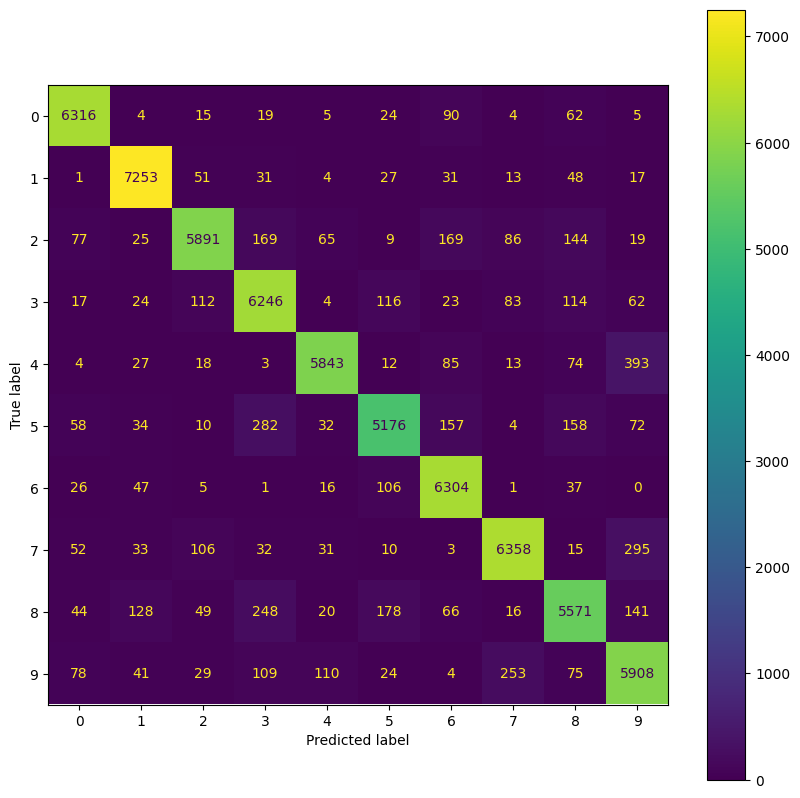

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

### 1.3 Data Augmentation
> The goal is to augment it to the point that there is a class of inputs that the model just can't learn -- we're artificially creating data that is difficult for the model, then we'll try some techniques for identifying when new, unseen inputs might be challenging for the model.

In [12]:
def noise(array, noise_factor=0.2):
    """Adds random noise to each image in the supplied array."""
    rng = np.random.default_rng()
    noisy_array = array + noise_factor * rng.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)

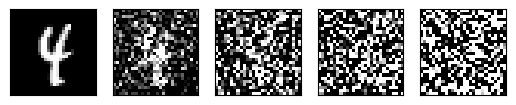

In [13]:
test = x_test[0].reshape((28,28))
fig, ax = plt.subplots(1,5)
ax[0].imshow(test, cmap='gray')
ax[1].imshow(noise(x_test[0], noise_factor=0.5).reshape((28,28)), cmap='gray')
ax[2].imshow(noise(x_test[0], noise_factor=1).reshape((28,28)), cmap='gray')
ax[3].imshow(noise(x_test[0], noise_factor=1.5).reshape((28,28)), cmap="gray")
ax[4].imshow(noise(x_test[0], noise_factor=3).reshape((28,28)), cmap="gray")
for axis in ax: axis.set_xticks([]); axis.set_yticks([])

In [14]:
x_test_noised_low = noise(x_test, noise_factor=0.5)
x_test_noised_med = noise(x_test, noise_factor=1)
x_test_noised_high = noise(x_test, noise_factor=1.5)
x_test_noised_extreme = noise(x_test, noise_factor=3)

x_test_total = np.concatenate((x_test_noised_low, x_test_noised_med, x_test_noised_high, x_test_noised_extreme), axis=0)
y_test_total = np.concatenate([y_test]*4, axis=0)

In [15]:
x_train_noised_low = noise(x_train, noise_factor=0.5)
x_train_noised_med = noise(x_train, noise_factor=1)
x_train_noised_high = noise(x_train, noise_factor=1.5)
x_train_noised_extreme = noise(x_train, noise_factor=3)

x_train_total = np.concatenate((x_train_noised_low, x_train_noised_med, x_train_noised_high, x_train_noised_extreme), axis=0)
y_train_total = np.concatenate([y_train]*4, axis=0)

### 1.4 Retrain Model

In [16]:
history = model.fit(x_train_total, y_train_total, 
          epochs=5, batch_size=128, shuffle=True, 
          validation_data=(x_test_total,y_test_total), verbose = 2,
          callbacks=[checkpoint])

Epoch 1/5


2024-05-06 15:02:59.822294: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 784: 0.897278, expected 0.597161
2024-05-06 15:02:59.822351: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786: 1.27047, expected 0.970349
2024-05-06 15:02:59.822361: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 787: 1.85635, expected 1.55624
2024-05-06 15:02:59.822370: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 788: 1.71215, expected 1.41203
2024-05-06 15:02:59.822378: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 797: 1.67035, expected 1.37024
2024-05-06 15:02:59.822387: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 810: 1.67093, expected 1.37082
2024-05-06 15:02:59.822395: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 811: 1.41687, expected 1.11675
2024-05-06 15:02:59.822409: E external


Epoch 1: val_accuracy did not improve from 0.91526
110/110 - 11s - 99ms/step - accuracy: 0.3098 - loss: 2.0542 - val_accuracy: 0.5202 - val_loss: 1.5836
Epoch 2/5

Epoch 2: val_accuracy did not improve from 0.91526
110/110 - 3s - 31ms/step - accuracy: 0.4416 - loss: 1.6091 - val_accuracy: 0.5647 - val_loss: 1.3571
Epoch 3/5

Epoch 3: val_accuracy did not improve from 0.91526
110/110 - 4s - 33ms/step - accuracy: 0.4977 - loss: 1.4718 - val_accuracy: 0.5862 - val_loss: 1.2769
Epoch 4/5

Epoch 4: val_accuracy did not improve from 0.91526
110/110 - 4s - 32ms/step - accuracy: 0.5121 - loss: 1.4166 - val_accuracy: 0.5956 - val_loss: 1.2236
Epoch 5/5

Epoch 5: val_accuracy did not improve from 0.91526
110/110 - 3s - 32ms/step - accuracy: 0.5318 - loss: 1.3671 - val_accuracy: 0.5960 - val_loss: 1.2239


#### 1.4.1 Model metrics on augmented data

##### 1.4.1.1 Overall Performance

In [17]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model.predict(x_test_total), axis=1)
print(f"Accuracy on all images: {accuracy_score(y_test_total, y_pred)}")

y_pred = np.argmax(model.predict(x_test), axis=1)
print(f"Accuracy on normal images: {accuracy_score(y_test, y_pred)}")

8313/8313 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Accuracy on all images: 0.596
2079/2079 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Accuracy on normal images: 0.9146315789473685


##### 1.4.1.2 Low Noise

2079/2079 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Accuracy on noisy images: 0.884375939849624



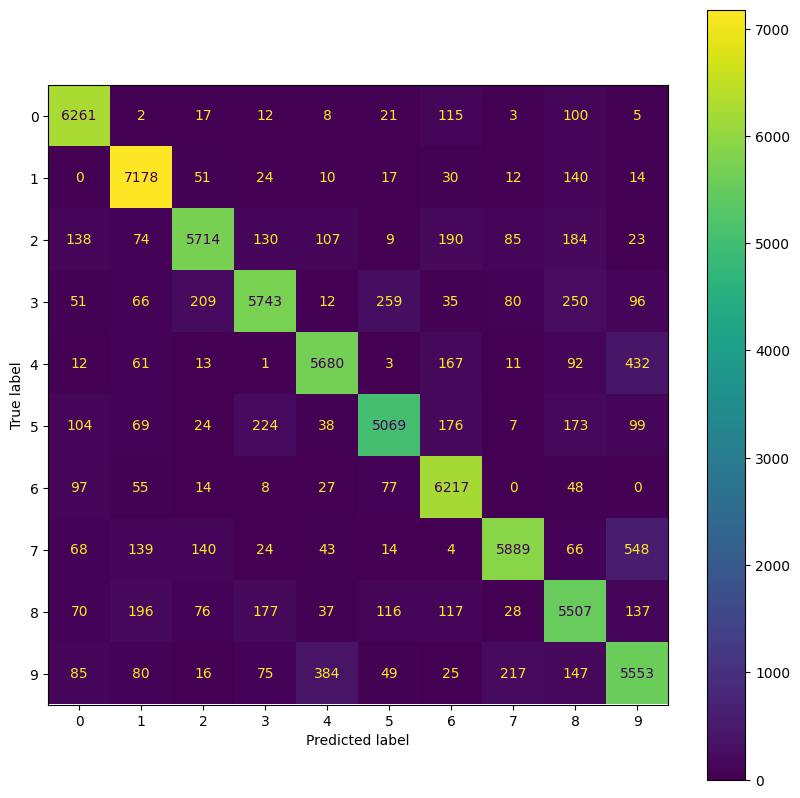

In [18]:
# generate confusion matrix with low noise validation data
y_pred = model.predict(x_test_noised_low)

# map predictions to integer encoding
y_pred = np.argmax(y_pred, axis=1)

print(f"Accuracy on noisy images: {accuracy_score(y_test, y_pred)}")
print()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

##### 1.4.1.3 Medium Noise

2079/2079 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Accuracy on noisy images: 0.7222406015037593



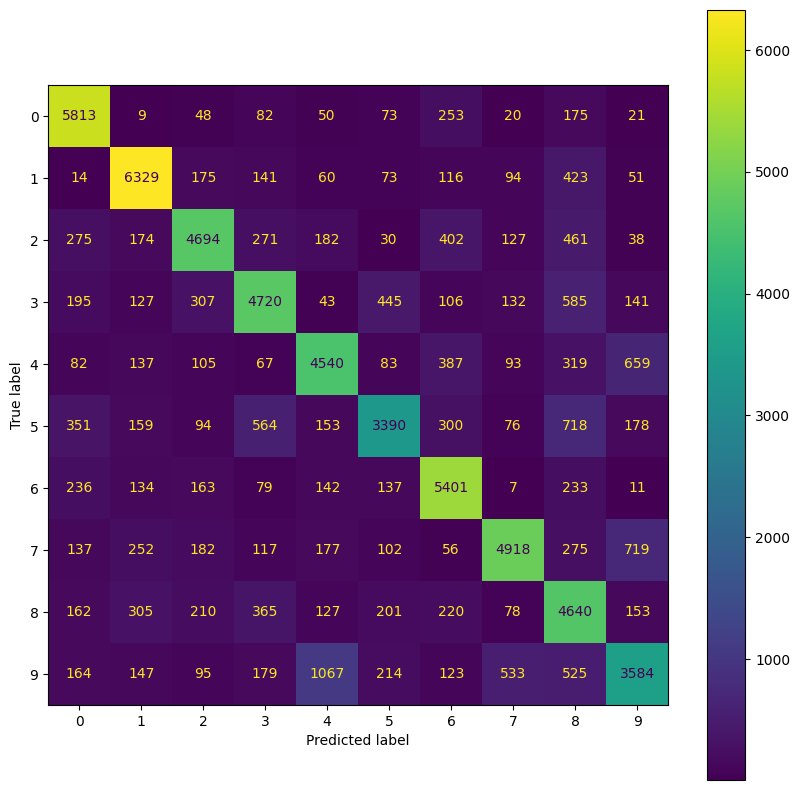

In [19]:
# generate confusion matrix with medium noise validation data
y_pred = model.predict(x_test_noised_med)

# map predictions to integer encoding
y_pred = np.argmax(y_pred, axis=1)

print(f"Accuracy on noisy images: {accuracy_score(y_test, y_pred)}")
print()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

##### 1.4.1.4 High Noise

2079/2079 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Accuracy on noisy images: 0.5200902255639098



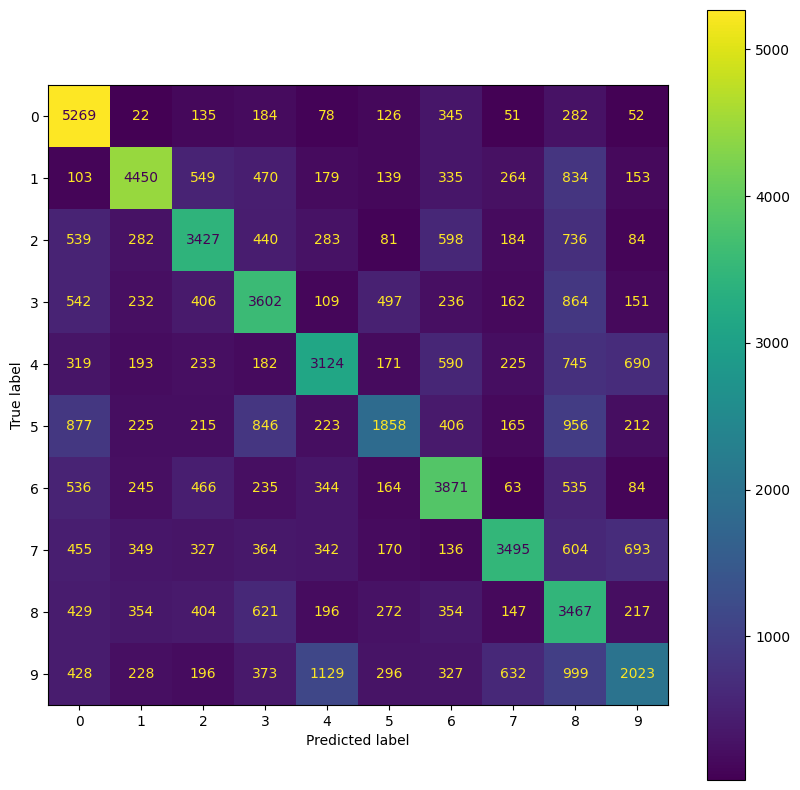

In [20]:
# generate confusion matrix with high noise validation data
y_pred = model.predict(x_test_noised_high)

# map predictions to integer encoding
y_pred = np.argmax(y_pred, axis=1)

print(f"Accuracy on noisy images: {accuracy_score(y_test, y_pred)}")
print()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

##### 1.4.1.5 Very High Noise

2079/2079 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Accuracy on noisy images: 0.25729323308270674



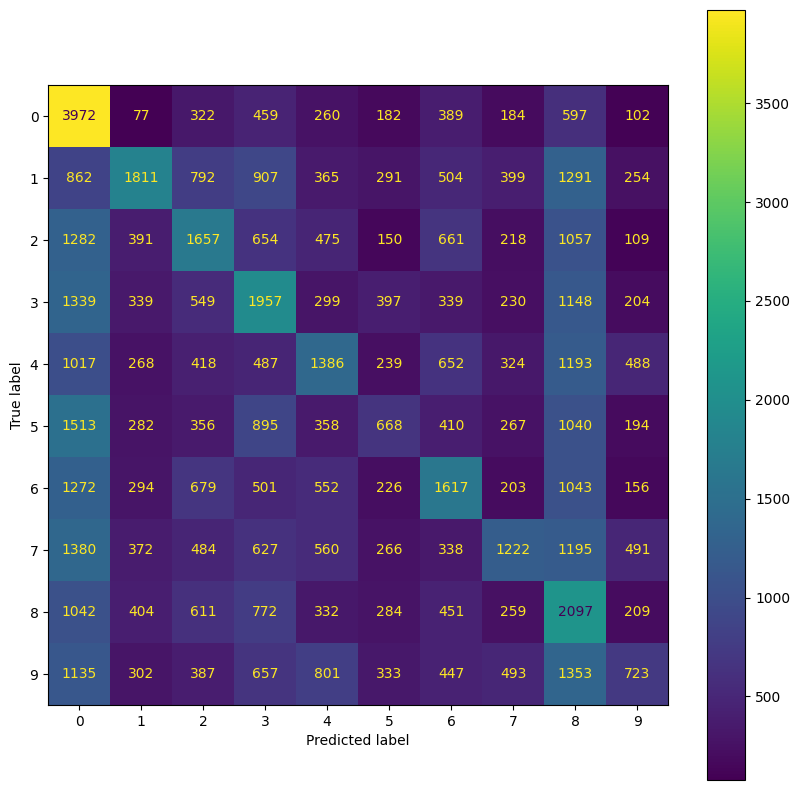

In [21]:
# generate confusion matrix with extreme noise validation data
y_pred = model.predict(x_test_noised_extreme)

# map predictions to integer encoding
y_pred = np.argmax(y_pred, axis=1)

print(f"Accuracy on noisy images: {accuracy_score(y_test, y_pred)}")
print()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

# 2. Model 2
> Building confidence estimation models using an autoencoder and different kNN regression strategies

### 2.1 Build & Train Autoencoder

#### 2.1.1 Architecture

In [22]:
# encoder
img_input = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(img_input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(512, activation="relu", name="latent_space")(x)

encoder = keras.models.Model(img_input, x)


In [23]:
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(7*7*32, activation="relu")(x)
x = layers.Reshape((7,7,32))(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = keras.models.Model(img_input, x)

In [24]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [25]:
encoder.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 512)            │       262,656 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,075,552 (4.10 MB)

 Trainable params: 1,075,552 (4.10 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
autoencoder.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       803,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1568)           │       804,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,161,377 (8.24 MB)

 Trainable params: 2,161,377 (8.24 MB)

 Non-trainable params: 0 (0.00 B)

#### 2.1.2 Training

In [27]:
x_train_aec, x_leftover, y_train_aec, y_leftover = train_test_split(x_test_total, y_test_total, test_size=0.75, random_state=6)

In [28]:
history = autoencoder.fit(x_train_aec, x_train_aec,
                          epochs=10, batch_size=128, shuffle=True, 
                          verbose = 2)

Epoch 1/10
520/520 - 10s - 18ms/step - loss: 0.6337
Epoch 2/10
520/520 - 3s - 5ms/step - loss: 0.6122
Epoch 3/10
520/520 - 3s - 5ms/step - loss: 0.6010
Epoch 4/10
520/520 - 3s - 5ms/step - loss: 0.5969
Epoch 5/10
520/520 - 3s - 5ms/step - loss: 0.5907
Epoch 6/10
520/520 - 3s - 5ms/step - loss: 0.5876
Epoch 7/10
520/520 - 3s - 5ms/step - loss: 0.5869
Epoch 8/10
520/520 - 3s - 5ms/step - loss: 0.5838
Epoch 9/10
520/520 - 3s - 5ms/step - loss: 0.5828
Epoch 10/10
520/520 - 3s - 5ms/step - loss: 0.5793


#### 2.1.3 Visually Assess Results
> A quick test to check if the autoencoder encodes some sort of information about noise

In [29]:
def display(array1, array2):
    """Displays 10 images from each array."""
    n = 10
    images1 = array1[:n, :]
    images2 = array2[:n, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 649ms/step


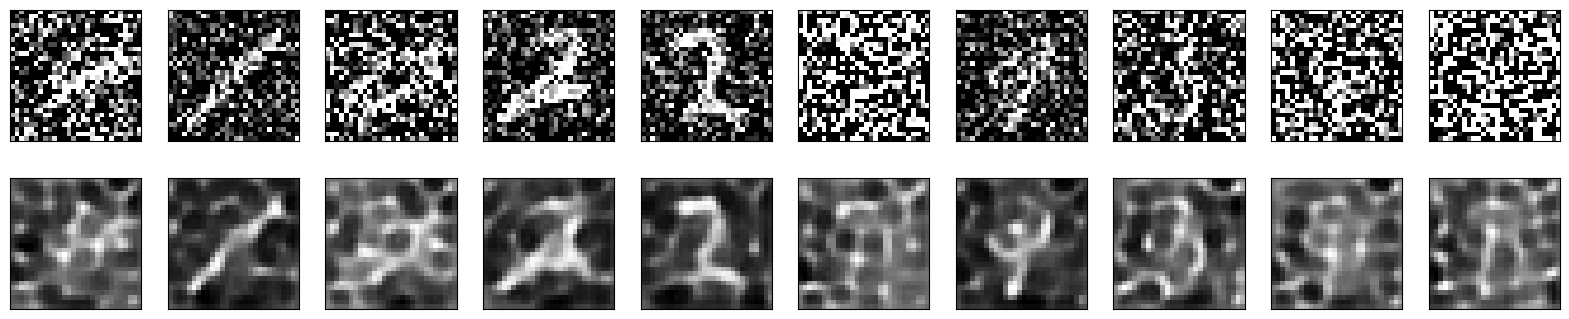

In [30]:
display(x_leftover[:10], autoencoder.predict(x_leftover[:10]))

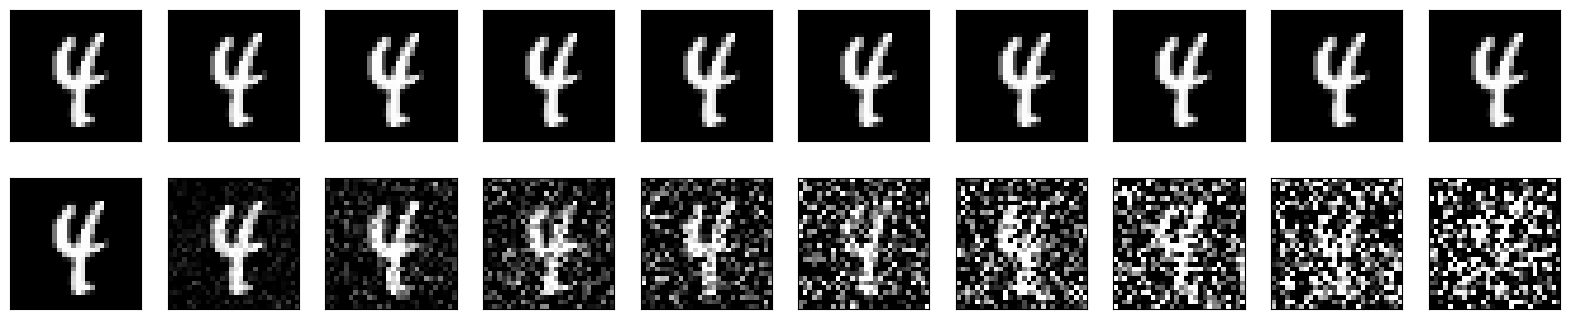

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


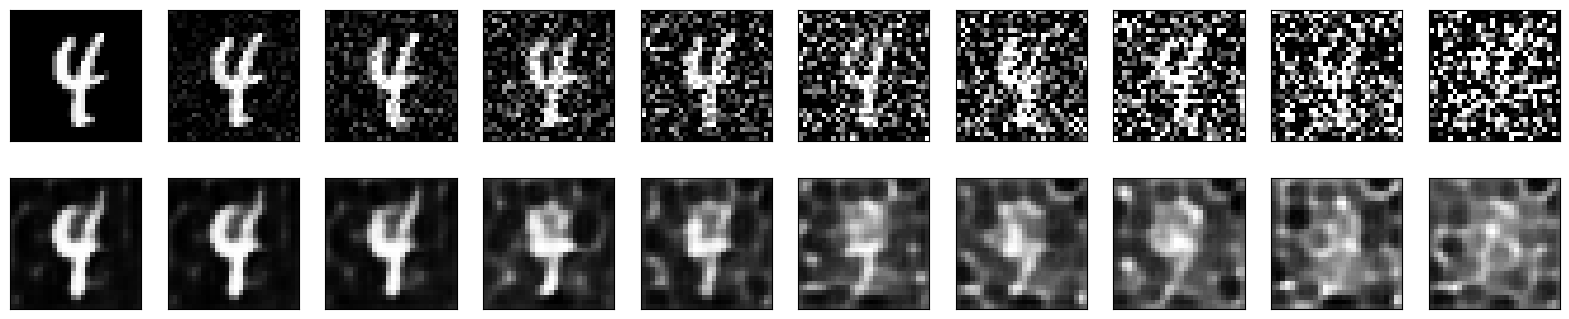

In [31]:
n = 10
image = x_test[0]
noisy_images = [noise(image, float(i/10)) for i in range(n)]
display(np.array([image for _ in range(n)]), np.array(noisy_images))
predictions = autoencoder.predict(np.array(noisy_images))
display(np.array(noisy_images), predictions)

#### 2.1.4 PCA of latent space
> We want to check that the latent space has a dimension that encodes "difficulty" ie. noise level.

In [32]:
# PCA then label with noise level
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
pca = PCA(n_components=2)
tsne = TSNE(n_components=2)

# sample test data (for speed)
sample_size = 1000
latent_dim = 512
extreme_noise_sample = x_test_noised_extreme[:sample_size]
high_noise_sample = x_test_noised_high[:sample_size]
med_noise_sample = x_test_noised_med[:sample_size]
low_noise_sample = x_test_noised_low[:sample_size]

# map into latent space
encoded_extreme = encoder.predict(extreme_noise_sample).reshape(sample_size, latent_dim)
encoded_high = encoder.predict(high_noise_sample).reshape(sample_size, latent_dim)
encoded_med = encoder.predict(med_noise_sample).reshape(sample_size, latent_dim)
encoded_low = encoder.predict(low_noise_sample).reshape(sample_size, latent_dim)
encoded_no = encoder.predict(x_test[:sample_size]).reshape(sample_size, latent_dim)

latent_reps = np.concatenate([encoded_extreme, encoded_high, encoded_med, encoded_low, encoded_no])
noise_levels = np.concatenate((np.ones(len(encoded_extreme))*4, np.ones(len(encoded_high))*3, np.ones(len(encoded_med))*2, np.ones(len(encoded_low)), np.zeros(len(encoded_no))))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [33]:
latent_reps = scaler.fit_transform(latent_reps)
pca_predictions = pca.fit_transform(latent_reps)
tsne_predictions = tsne.fit_transform(latent_reps)

In [34]:
pca_df = pd.DataFrame(pca_predictions, columns=['PC1', 'PC2'])
tsne_df = pd.DataFrame(tsne_predictions, columns=['t-SNE1', 't-SNE2'])

pca_df['Noise level'] = noise_levels
tsne_df['Noise level'] = noise_levels
# convert noise levels to string colors
import matplotlib.colors as mcolors
color_map = {i:color for i,color in enumerate(mcolors.TABLEAU_COLORS.keys())}
pca_df['Noise level'] = pca_df['Noise level'].map(color_map)
tsne_df['Noise level'] = tsne_df['Noise level'].map(color_map)
[print(f"Noise level {i} : {color_map[i]}") for i in range(5)]

Noise level 0 : tab:blue
Noise level 1 : tab:orange
Noise level 2 : tab:green
Noise level 3 : tab:red
Noise level 4 : tab:purple


[None, None, None, None, None]

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('PCA')
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Noise level'], alpha=0.5, s=10)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.subplot(1, 2, 2)
plt.title('t-SNE')
plt.scatter(tsne_df['t-SNE1'], tsne_df['t-SNE2'], c=tsne_df['Noise level'], alpha=0.5, s=10)
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

plt.show()

### 2.2 Create input dataset for Model 2

In [36]:
x_knn_train, x_knn_leftover, y_knn_train, y_knn_leftover = train_test_split(x_leftover, y_leftover, train_size=0.6, shuffle=True, random_state=6)
x_knn_val, x_knn_test, y_knn_val, y_knn_test = train_test_split(x_knn_leftover, y_knn_leftover, train_size=0.5, shuffle=True, random_state=6)

In [37]:
y_pred = np.argmax(model.predict(x_knn_train), axis=1)
# Calculate correctness: 0 for wrong, 1 for right
correctness = (y_pred == y_knn_train).astype(int)

3711/3741 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2024-05-06 15:05:20.964274: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 1.71635, expected 0.821095
2024-05-06 15:05:20.964328: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.02731, expected 2.13205
2024-05-06 15:05:20.964340: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 2.37726, expected 1.482
2024-05-06 15:05:20.964348: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 2.44146, expected 1.5462
2024-05-06 15:05:20.964357: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 2.74698, expected 1.85172
2024-05-06 15:05:20.964365: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.03901, expected 2.14375
2024-05-06 15:05:20.964373: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 2.92498, expected 2.02973
2024-05-06 15:05:20.964381: E external/local_xla/xla/serv

3741/3741 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


In [38]:
import pandas as pd
model_two_input_data = pd.DataFrame({
    'predicted_class': y_pred,
    'actual_class': y_knn_train,
    'correctness': correctness
})

print(model_two_input_data.head())

   predicted_class  actual_class  correctness
0                4             4            1
1                5             5            1
2                6             6            1
3                7             7            1
4                4             4            1


### 2.3 Map all image data into the latent space

#### 2.3.1 Predictions from encoder

In [39]:
x_train_encoded = encoder.predict(x_knn_train)
x_val_encoded = encoder.predict(x_knn_val)
x_test_encoded = encoder.predict(x_knn_test)

3741/3741 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1241/1247 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2024-05-06 15:05:33.189283: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 784: 1.3995, expected 0.699251
2024-05-06 15:05:33.189338: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 785: 2.82437, expected 2.12412
2024-05-06 15:05:33.189348: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 786: 1.85926, expected 1.15901
2024-05-06 15:05:33.189356: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 787: 1.98117, expected 1.28092
2024-05-06 15:05:33.189363: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 788: 2.42357, expected 1.72332
2024-05-06 15:05:33.189371: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 789: 2.66285, expected 1.9626
2024-05-06 15:05:33.189379: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 790: 2.58016, expected 1.87991
2024-05-06 15:05:33.189386: E external/loc

1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [40]:
np.min(x_train_encoded), np.max(x_train_encoded)

(0.0, 6.932276)

#### 2.3.2 Data from the 'belly' of Model 1

In [41]:
x_train_belly = belly_model.predict(x_knn_train)
x_val_belly = belly_model.predict(x_knn_val)
x_test_belly = belly_model.predict(x_knn_test)

3741/3741 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [42]:
np.min(x_train_belly), np.max(x_train_belly)

(0.0, 8.375464)

#### 2.3.3 Complete "latent space" representations

In [43]:
# normalize encodings and bellies before combining
def z_score_norm(arr:np.array, mean:float, std:float):
    return (arr-mean)/std

encoded_mean, encoded_std = np.mean(x_train_encoded), np.std(x_train_encoded)
x_train_encoded, x_val_encoded, x_test_encoded = (z_score_norm(arr, encoded_mean, encoded_std) for arr in (x_train_encoded, x_val_encoded, x_test_encoded))
print("Encodings: [", np.min(x_train_encoded),',', np.max(x_train_encoded),"]")

belly_mean, belly_std = np.mean(x_train_belly), np.std(x_train_belly)
x_train_belly, x_val_belly, x_test_belly = (z_score_norm(arr, belly_mean, belly_std) for arr in (x_train_belly, x_val_belly, x_test_belly))
print("Bellies: [", np.min(x_train_belly),',',np.max(x_train_belly),"]")

Encodings: [ -1.0312369 , 7.103146 ]
Bellies: [ -0.55478865 , 10.658678 ]


In [44]:
# partial encoding copies
x_train_no_belly, x_val_no_belly, x_test_no_belly = np.copy(x_train_encoded), np.copy(x_val_encoded), np.copy(x_test_encoded)

# "full" version
x_train_encoded = np.concatenate([x_train_encoded, x_train_belly], axis=1)
x_val_encoded = np.concatenate([x_val_encoded, x_val_belly], axis=1)
x_test_encoded = np.concatenate([x_test_encoded, x_test_belly], axis=1)

### 2.4 kNN algorithm to predict % confidence

#### 2.4.1 Fit kNN model to `x_train_encoded`

In [45]:
from sklearn.neighbors import NearestNeighbors

# Number of neighbors is arbitrarily set to 30 currently
knn = NearestNeighbors(n_neighbors=30)
knn.fit(x_train_encoded)

NearestNeighbors(n_neighbors=30)

In [46]:
distances, indices = knn.kneighbors(x_val_encoded)

#### 2.4.2 Calculate unweighted average of neighbor's correctness

In [47]:
unweighted_confidences = []
for i in range(len(x_val_encoded)):
    confidence = np.mean(model_two_input_data.iloc[indices[i]]['correctness'].to_numpy())
    unweighted_confidences.append(confidence)

In [48]:
# later, we'll use the sklearn library's calibration plots to do this automatically, 
# but it's been instructive to see the internals and do it ourselves
def confidence_vs_accuracy(y_preds, y_trues, confidences, threshold=20, title='Accuracy vs. Confidence Level', plot=True):
    results = {x/100: {'total_number': 0, 'number_correct': 0, 'accuracy':0} for x in range(101)}
    for i, conf in enumerate(confidences):
        conf = round(float(conf),2)
        results[conf]['total_number'] += 1
        results[conf]['number_correct'] += 1 if y_trues[i] == y_preds[i] else 0

    for k in results.keys():
        results[k]['accuracy'] = (np.round(results[k]['number_correct'] / results[k]['total_number'],3) 
                                  if results[k]['total_number'] > 0 else 0)
        
    valid_confs = [k for k in results.keys() if results[k]['total_number'] > threshold]
    valid_accs = [results[k]['accuracy'] for k in valid_confs]
    
    if plot:
        fig = plt.plot(valid_confs, valid_accs, 'o-')
        plt.plot([0,1], [0,1], "r--", label='x=y')
        plt.title(title)
        plt.xlabel('Confidence Level')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.show()

    return np.corrcoef(valid_confs, valid_accs)
    

1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


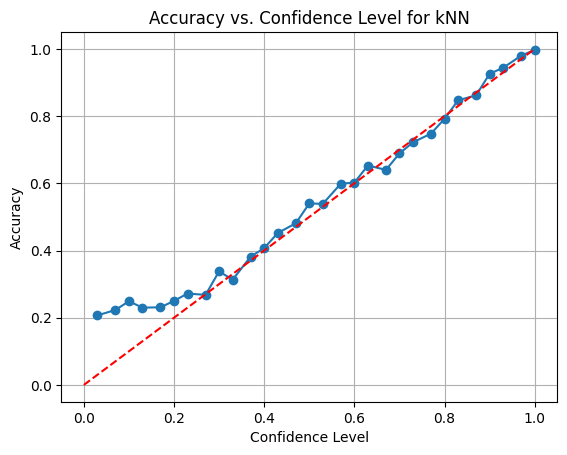

array([[1.       , 0.9897029],
       [0.9897029, 1.       ]])

In [49]:
val_preds = np.argmax(model.predict(x_knn_val),axis=1)
corr = confidence_vs_accuracy(val_preds, y_knn_val, unweighted_confidences,
                                  title="Accuracy vs. Confidence Level for kNN")
corr

#### 2.4.3 Compare to Sigmoid

1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


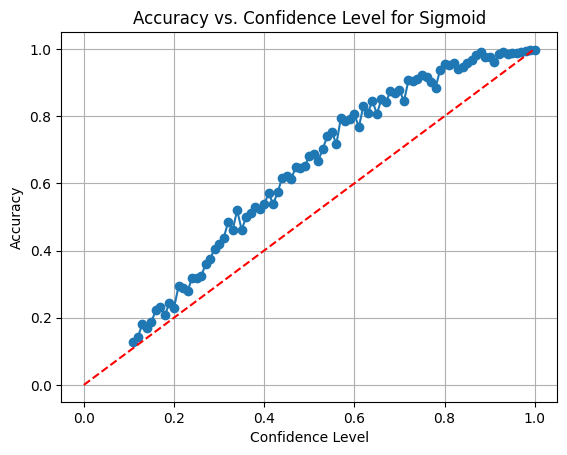

array([[1.        , 0.97618737],
       [0.97618737, 1.        ]])

In [50]:
val_outputs = model.predict(x_knn_val)
sigmoid_confidence = np.max(val_outputs, axis=1)
val_preds = np.argmax(val_outputs, axis=1)

corr = confidence_vs_accuracy(val_preds, y_knn_val, sigmoid_confidence, 
                                  title="Accuracy vs. Confidence Level for Sigmoid")
corr

In [51]:
test_preds = np.argmax(model.predict(x_knn_test),axis=1)

1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


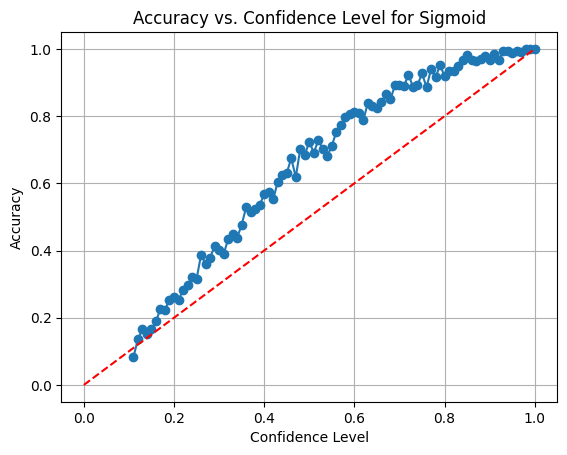

array([[1.        , 0.97263646],
       [0.97263646, 1.        ]])

In [52]:
test_outputs = model.predict(x_knn_test)
sigmoid_confidence = np.max(test_outputs, axis=1)

corr = confidence_vs_accuracy(test_preds, y_knn_test, sigmoid_confidence, 
                                  title="Accuracy vs. Confidence Level for Sigmoid")
corr

#### 2.4.4 Weighted average kNN

In [53]:
def weighted_average(indices, distances):
    weighted_sum = 0
    total_weight = 0
    for i, (index, distance) in enumerate(zip(indices, distances)):
        correctness = model_two_input_data.iloc[index]['correctness']
        
        if distance == 0: return 1 if correctness else 0
        
        weight = 1 / distance
        weighted_sum += correctness * weight
        total_weight += weight
    return weighted_sum / total_weight

1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


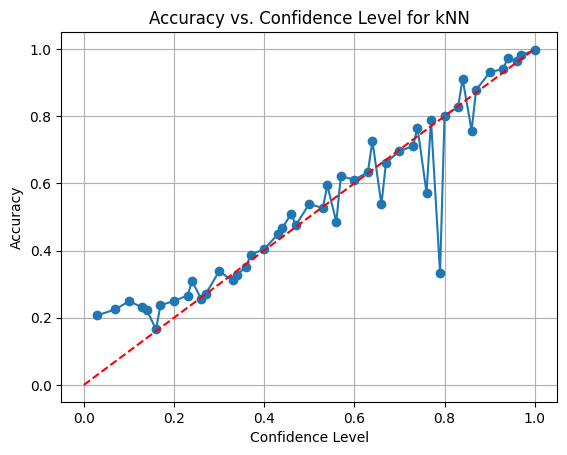

array([[1.        , 0.94513856],
       [0.94513856, 1.        ]])

In [54]:
val_outputs = model.predict(x_knn_val)
val_preds = np.argmax(val_outputs, axis=1)

weighted_confidences = []
for i in range(len(x_val_encoded)):
    confidence = weighted_average(indices[i], distances[i])
    weighted_confidences.append(confidence)

corr = confidence_vs_accuracy(val_preds, y_knn_val, weighted_confidences,
                                  title="Accuracy vs. Confidence Level for kNN")
corr

1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


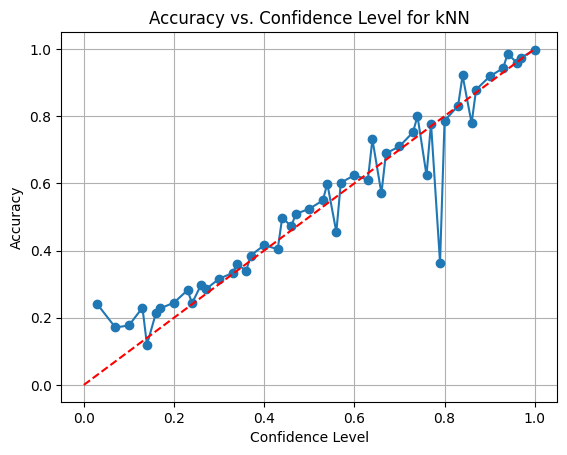

array([[1.        , 0.95431232],
       [0.95431232, 1.        ]])

In [55]:
knn = NearestNeighbors(n_neighbors=30)
knn.fit(x_train_encoded)
distances, indices = knn.kneighbors(x_test_encoded)

val_outputs = model.predict(x_knn_test)
val_preds = np.argmax(val_outputs, axis=1)

weighted_confidences = []
for i in range(len(x_test_encoded)):
    confidence = weighted_average(indices[i], distances[i])
    weighted_confidences.append(confidence)
    
corr = confidence_vs_accuracy(test_preds, y_knn_test, weighted_confidences,
                                  title="Accuracy vs. Confidence Level for kNN")
corr

#### 2.4.5 kNN Isolation Testing
##### <u>Three isolation tests using <b>unweighted</b> and <b>weighted</b> kNN algorithm:</u>
##### 1. Without gut feeling
##### 2. Only gut feeling
##### 3. Raw image
##### <i>Note: gut ~ belly

##### 2.4.5.1 Preparation

In [56]:
## Set up variables and define helper functions for kNN_run

# Set up static variables
test_preds = np.argmax(model.predict(x_knn_test),axis=1)
val_preds = np.argmax(model.predict(x_knn_val), axis=1)
y_true_val = [1 if y_knn_val[i] == val_preds[i] else 0 for i in range(len(y_knn_val))]
y_true_test = [1 if y_knn_test[i] == test_preds[i] else 0 for i in range(len(y_knn_test))]

# Define kNN_run helper functions 
def get_confidence(len_of_x, indices, distances, is_weighted):
    confidences = []
    if is_weighted:
        for i in range(len_of_x):
            confidence = weighted_average(indices[i], distances[i])
            confidences.append(confidence)
    else:
        for i in range(len_of_x):
            confidence = np.mean(model_two_input_data.iloc[indices[i]]['correctness'].to_numpy())
            confidences.append(confidence)
            
    return confidences

def plot_calibration(val_pred, val_true, test_pred, test_true, set_title):
    plt.plot(val_pred, val_true, marker='o', linewidth=1, label='Validation')
    plt.plot(test_pred, test_true, marker='o', linewidth=1, label='Test')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
    plt.xlabel('Confidence Level')
    plt.ylabel('Accuracy')
    plt.title(set_title)
    plt.legend()
    plt.show()

1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1247/1247 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [57]:
def kNN_run(x_train_encoded, x_val_encoded, x_test_encoded, is_weighted, set_title):
    new_knn = NearestNeighbors(n_neighbors=30)
    new_knn.fit(x_train_encoded)
    
    distances, indices = new_knn.kneighbors(x_val_encoded)
    val_confidence = get_confidence(len(x_val_encoded), indices, distances, is_weighted)
    val_true, val_pred = calibration_curve(y_true_val, val_confidence, n_bins=100)
    
    distances, indices = new_knn.kneighbors(x_test_encoded)
    test_confidence = get_confidence(len(x_test_encoded), indices, distances, is_weighted)
    test_true, test_pred = calibration_curve(y_true_test, test_confidence, n_bins=100)

    plot_calibration(val_pred, val_true, test_pred, test_true, set_title)
    
    return val_confidence, test_confidence

##### 2.4.5.2 Unweighted kNN

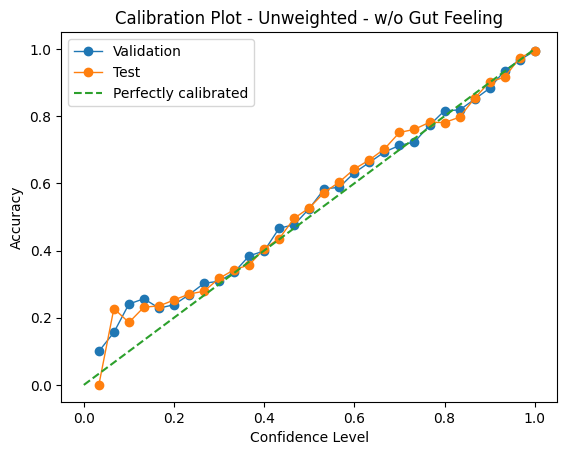

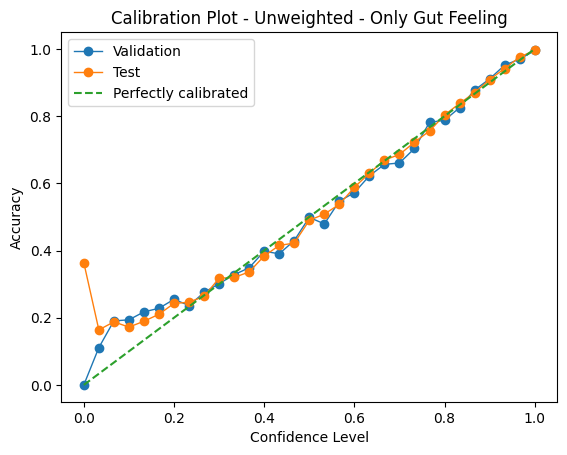

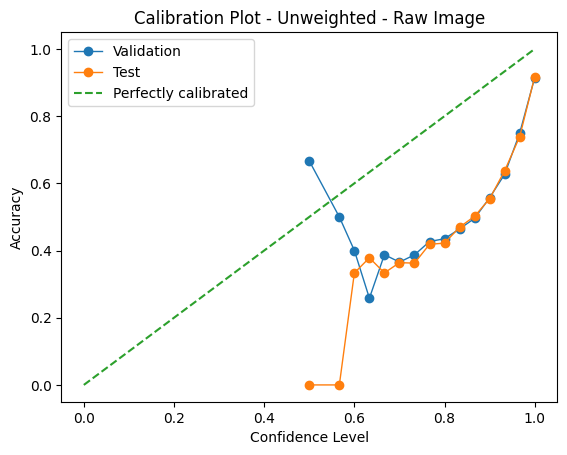

In [58]:
uw_no_belly_val, uw_no_belly_test = kNN_run(x_train_no_belly, x_val_no_belly, x_test_no_belly, False, 'Calibration Plot - Unweighted - w/o Gut Feeling')
uw_belly_val, uw_belly_test = kNN_run(x_train_belly, x_val_belly, x_test_belly, False, 'Calibration Plot - Unweighted - Only Gut Feeling')
uw_raw_val, uw_raw_test = kNN_run(x_knn_train.reshape((-1, 28*28)), x_knn_val.reshape((-1, 28*28)), x_knn_test.reshape((-1, 28*28)), False, 'Calibration Plot - Unweighted - Raw Image')

##### 2.4.5.3 Weighted kNN

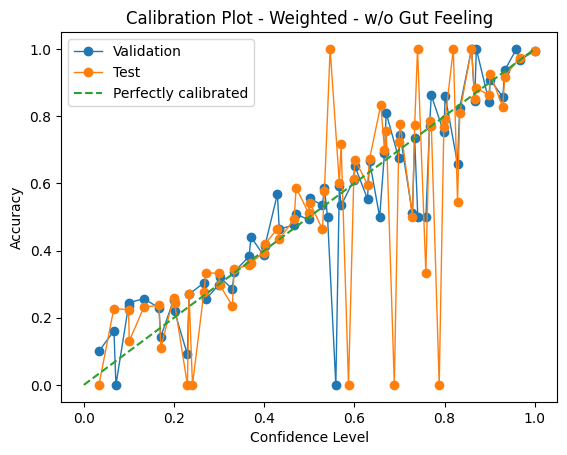

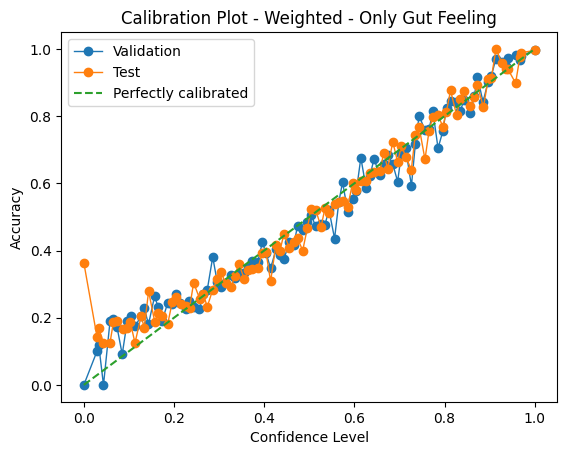

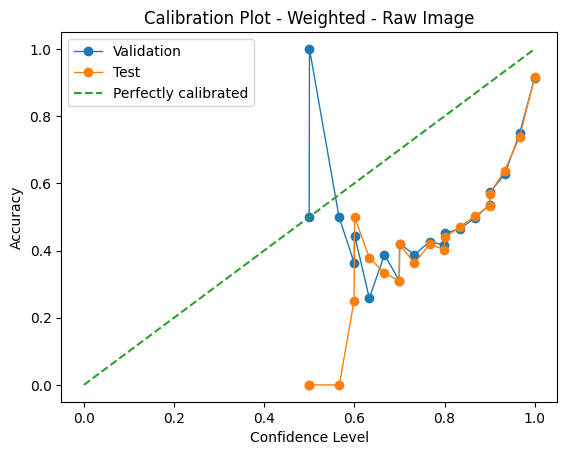

In [59]:
w_no_belly_val, w_no_belly_test = kNN_run(x_train_no_belly, x_val_no_belly, x_test_no_belly, True, 'Calibration Plot - Weighted - w/o Gut Feeling')
w_belly_val, w_belly_test = kNN_run(x_train_belly, x_val_belly, x_test_belly, True, 'Calibration Plot - Weighted - Only Gut Feeling')
w_raw_val, w_raw_test = kNN_run(x_knn_train.reshape((-1, 28*28)), x_knn_val.reshape((-1, 28*28)), x_knn_test.reshape((-1, 28*28)), True, 'Calibration Plot - Weighted - Raw Image')

#### 2.4.8 Optimize k for correlation for unweighted

Text(0.5, 1.0, 'k vs. Accuracy-Confidence Correlation')

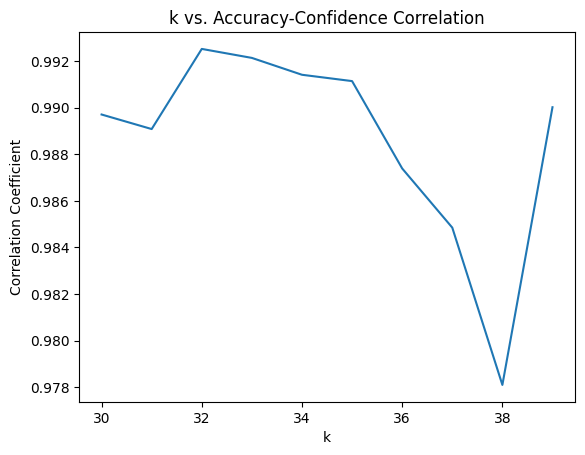

In [60]:
ks = np.arange(30, 40)
corrs = []
for k in ks:
    # fit model
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(x_train_encoded)
    
    # get distances, indices
    distances, indices = knn.kneighbors(x_val_encoded)
    
    # predict confidence
    unweighted_confidences = []
    for i in range(len(x_val_encoded)):
        confidence = np.mean(model_two_input_data.iloc[indices[i]]['correctness'].to_numpy())
        unweighted_confidences.append(confidence)
        
    # evaluate
    corr = confidence_vs_accuracy(val_preds, y_knn_val, unweighted_confidences,
                                  plot=False)
    corrs.append(corr[0,1])
    
plt.plot(ks, corrs)
# plt.xscale('log')
plt.xlabel('k')
plt.ylabel('Correlation Coefficient')
plt.title('k vs. Accuracy-Confidence Correlation')

In [61]:
best_k = ks[np.argmax(corrs)]

#### 2.4.6 Test best k on test set

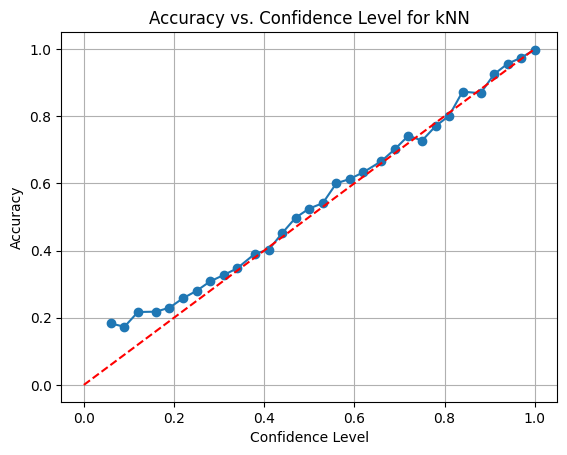

array([[1.        , 0.99624247],
       [0.99624247, 1.        ]])

In [62]:
knn = NearestNeighbors(n_neighbors=best_k)
knn.fit(x_train_encoded)
distances, indices = knn.kneighbors(x_test_encoded)

unweighted_confidences = []
for i in range(len(x_test_encoded)):
    confidence = np.mean(model_two_input_data.iloc[indices[i]]['correctness'].to_numpy())
    unweighted_confidences.append(confidence)
    
corr = confidence_vs_accuracy(test_preds, y_knn_test, unweighted_confidences,
                                  title="Accuracy vs. Confidence Level for kNN")
corr

# 3. Evaluation

#### Section Overview: Evaluation Categories + Metrics
##### <u>Combo Metrics</u>: Brier Score (Calibration + Sharpness), Log Loss (Calibration + Discrimination)
##### <u>Calibration</u>: How closely predicted confidence matches actual outcome
##### Calibration metrics: Calibration Curve, Expected Calibration Error (ECE)
##### <u>Sharpness</u>: Concentration of probability forecasts; sharper forecasts provide more certain predictions (close to 0 or 1)
##### Sharpness metrics: Variance of Confidence Predictions, Histogram of Confidence Predictions, Proportion Belonging to Extreme Threshold
##### <u>Discrimination</u>: Ability to differentiate between classes / outcomes
##### Discrimination metrics: AUC / ROC

### 3.1 Prep for Evaluations

In [63]:
y_true = [1 if y_knn_test[i] == test_preds[i] else 0 for i in range(len(y_knn_test))]

### 3.2 Combo Metrics

#### Brier Score

In [64]:
## Brier scores are basically the holy grail for forecasting evaluation
## Combines calibration and discrimination 

model_1_y_base = [0.5] * len(y_true)
print(f"Model 1: Prediction Brier Score: {brier_score_loss(y_true, model_1_y_base)}")

# Brier Score for Model 1 - Sigmoid
print(f"Model 1: Sigmoid Confidence Brier Score: {brier_score_loss(y_true, sigmoid_confidence)}")

# # Brier Scores for Model 2; Weighted + Unweighted
print(f"Model 2: Weighted Confidence Brier Score: {brier_score_loss(y_true, weighted_confidences)}")
print(f"Model 2: Unweighted Confidence Brier Score: {brier_score_loss(y_true, unweighted_confidences)}")

Model 1: Prediction Brier Score: 0.25
Model 1: Sigmoid Confidence Brier Score: 0.16949215708748117
Model 2: Weighted Confidence Brier Score: 0.16658921213514807
Model 2: Unweighted Confidence Brier Score: 0.16676138588659148


In [65]:
## Brier Scores for Iso-Tests
print(f"No Belly W Brier Score: {brier_score_loss(y_true, w_no_belly_test)}")
print(f"Only Belly W Brier Score: {brier_score_loss(y_true, w_belly_test)}")
print(f"Raw Image W Brier Score: {brier_score_loss(y_true, w_raw_test)}")
print("\n")
print(f"No Belly UW Brier Score: {brier_score_loss(y_true, uw_no_belly_test)}")
print(f"Only Belly UW Brier Score: {brier_score_loss(y_true, uw_belly_test)}")
print(f"Raw Image UW Brier Score: {brier_score_loss(y_true, uw_raw_test)}")

No Belly W Brier Score: 0.1809232229204515
Only Belly W Brier Score: 0.15504346179014372
Raw Image W Brier Score: 0.3150477739003854


No Belly UW Brier Score: 0.18099793929267613
Only Belly UW Brier Score: 0.15525229741019214
Raw Image UW Brier Score: 0.31505783904204965


#### Log Loss

In [66]:
# Log Loss
# Like Brier Score, considers both calibration and sharpness of predictions
# Lower val -> better performance--0 is ideal
# High val -> model making pred very diff from act labels, esp when
# predicting with high confidence = bad

print("Log Loss for Sigmoid:", log_loss(y_true, sigmoid_confidence))
print("Log Loss for Weighted:", log_loss(y_true, weighted_confidences))
print("Log Loss for Unweighted:", log_loss(y_true, unweighted_confidences))

Log Loss for Sigmoid: 0.501947281665662
Log Loss for Weighted: 0.4995231413935959
Log Loss for Unweighted: 0.4985185506534551


In [67]:
## Log Loss for Iso-Tests
print(f"No Belly W Log Loss: {log_loss(y_true, w_no_belly_test)}")
print(f"Only Belly W Log Loss: {log_loss(y_true, w_belly_test)}")
print(f"Raw Image W Log Loss: {log_loss(y_true, w_raw_test)}")
print("\n")
print(f"No Belly UW Log Loss: {log_loss(y_true, uw_no_belly_test)}")
print(f"Only Belly UW Log Loss: {log_loss(y_true, uw_belly_test)}")
print(f"Raw Image UW Log Loss: {log_loss(y_true, uw_raw_test)}")

No Belly W Log Loss: 0.5440245716039589
Only Belly W Log Loss: 0.4886959960941075
Raw Image W Log Loss: 1.247284513074854


No Belly UW Log Loss: 0.5442403760006143
Only Belly UW Log Loss: 0.4892807782327933
Raw Image UW Log Loss: 1.2473187940683785


### 3.3 Calibration

#### 3.3.1 Calibration Curves

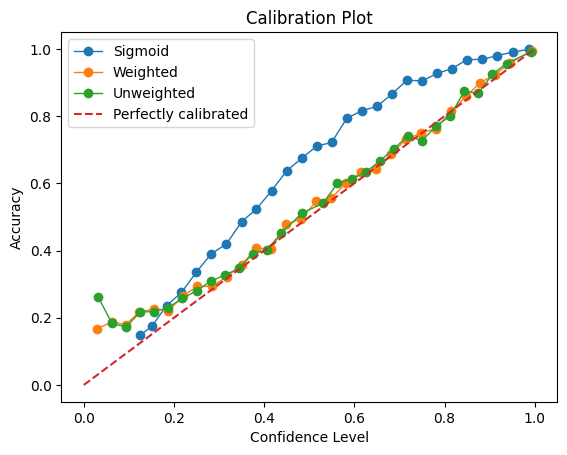

In [103]:
s_true, s_pred = calibration_curve(y_true, sigmoid_confidence, n_bins=30)
w_true, w_pred = calibration_curve(y_true, weighted_confidences, n_bins=30)
uw_true, uw_pred = calibration_curve(y_true, unweighted_confidences, n_bins=30)

plt.plot(s_pred, s_true, marker='o', linewidth=1, label='Sigmoid')
plt.plot(w_pred, w_true, marker='o', linewidth=1, label='Weighted')
plt.plot(uw_pred, uw_true, marker='o', linewidth=1, label='Unweighted')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Confidence Level')
plt.ylabel('Accuracy')
plt.title('Calibration Plot')
plt.legend()
plt.savefig('calibration_plot.png', transparent=True)

plt.show()

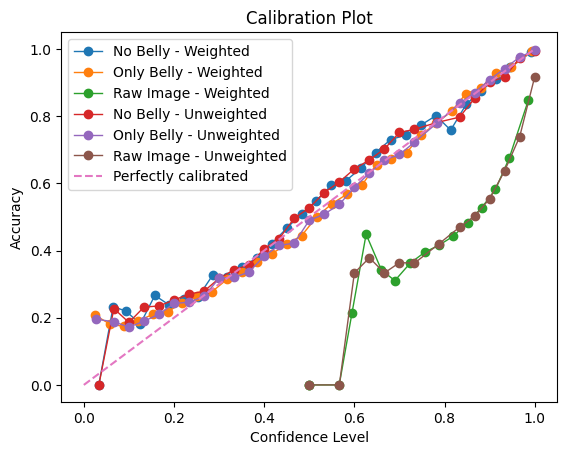

In [102]:
nbw_true, nbw_pred = calibration_curve(y_true, w_no_belly_test, n_bins=30)
obw_true, obw_pred = calibration_curve(y_true, w_belly_test, n_bins=30)
riw_true, riw_pred = calibration_curve(y_true, w_raw_test, n_bins=30)

nbuw_true, nbuw_pred = calibration_curve(y_true, uw_no_belly_test, n_bins=30)
obuw_true, obuw_pred = calibration_curve(y_true, uw_belly_test, n_bins=30)
riuw_true, riuw_pred = calibration_curve(y_true, uw_raw_test, n_bins=30)

plt.plot(nbw_pred, nbw_true, marker='o', linewidth=1, label='No Belly - Weighted')
plt.plot(obw_pred, obw_true, marker='o', linewidth=1, label='Only Belly - Weighted')
plt.plot(riw_pred, riw_true, marker='o', linewidth=1, label='Raw Image - Weighted')
plt.plot(nbuw_pred, nbuw_true, marker='o', linewidth=1, label='No Belly - Unweighted')
plt.plot(obuw_pred, obuw_true, marker='o', linewidth=1, label='Only Belly - Unweighted')
plt.plot(riuw_pred, riuw_true, marker='o', linewidth=1, label='Raw Image - Unweighted')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Confidence Level')
plt.ylabel('Accuracy')
plt.title('Calibration Plot')
plt.legend()
plt.savefig('six_remaining_calibration_plot.png', transparent=True)

plt.show()

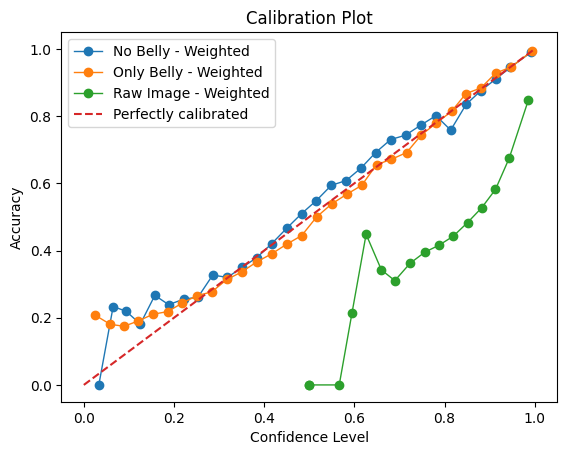

In [105]:
plt.plot(nbw_pred, nbw_true, marker='o', linewidth=1, label='No Belly - Weighted')
plt.plot(obw_pred, obw_true, marker='o', linewidth=1, label='Only Belly - Weighted')
plt.plot(riw_pred, riw_true, marker='o', linewidth=1, label='Raw Image - Weighted')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Confidence Level')
plt.ylabel('Accuracy')
plt.title('Calibration Plot')
plt.legend()
plt.savefig('three_weighted_remaining_calibration_plot.png', transparent=True)

plt.show()

#### 3.3.2 Expected Calibration Error
##### <u>Definition</u>: Weighted average of absolute difference between predicted and true across bins, weighted by the number of samples in each bin. 
##### Like calibration plots, they are a more direct measure of the discrepancy btwn predicted prob and actual outcomes than correlation. 
##### Correlation fails to capture absolute discrepancies between pred and obs. For instance, if all probs are 10% higher, high corr suggests strong confidence predictions, but actual calibration is poor. 
##### Intepretation: ECE of X means that predicted confidences are only 100X% as different from true accuracies on average.

In [69]:
# Expected Calibration Error

def calculate_ece(y_true, y_probs, bins):
    """Calculate the Expected Calibration Error with specified bin count."""
    prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=bins)
    
    actual_bins = np.linspace(0, 1, len(prob_true) + 1)
    bin_counts = np.histogram(y_probs, bins=actual_bins, range=(0,1))[0]

    ece = np.sum(np.abs(prob_pred - prob_true) * bin_counts) / len(y_probs)
    return ece

def cross_validate_ece(y_true, y_probs, bins_list, n_splits=5):
    """Perform K-Fold cross-validation to evaluate ECE across different bin sizes."""
    y_true = np.array(y_true)
    y_probs = np.array(y_probs)
    kf = KFold(n_splits=n_splits)
    ece_scores = {bins: [] for bins in bins_list}

    for train_index, test_index in kf.split(y_true):
        y_train_true, y_test_true = y_true[train_index], y_true[test_index]
        y_train_probs, y_test_probs = y_probs[train_index], y_probs[test_index]
        for bins in bins_list:
            ece_score = calculate_ece(y_test_true, y_test_probs, bins)
            ece_scores[bins].append(ece_score)

    average_ece_scores = {bins: np.mean(scores) for bins, scores in ece_scores.items()}
    return average_ece_scores

bins_list = [10]

sigmoid_cv = cross_validate_ece(y_true, sigmoid_confidence, bins_list)
unweighted_cv = cross_validate_ece(y_true, weighted_confidences, bins_list)
weighted_cv = cross_validate_ece(y_true, unweighted_confidences, bins_list)

# Select the best bin size (the one with the lowest average ECE across datasets)
average_results = {bins: np.mean([sigmoid_cv[bins], weighted_cv[bins], unweighted_cv[bins]]) for bins in bins_list}
best_bin_size = min(average_results, key=average_results.get)
print(f"Best bin size across all datasets: {best_bin_size}\n")

print("ECE for Sigmoid:", calculate_ece(y_true, sigmoid_confidence, best_bin_size))
print("ECE for Weighted:", calculate_ece(y_true, weighted_confidences, best_bin_size))
print("ECE for Unweighted:", calculate_ece(y_true, unweighted_confidences, best_bin_size))


Best bin size across all datasets: 10

ECE for Sigmoid: 0.12056189642165535
ECE for Weighted: 0.01587287782240965
ECE for Unweighted: 0.017035783411758567


In [70]:
# ECE for Iso-Tests
print(f"No Belly W ECE: {calculate_ece(y_true, w_no_belly_test, best_bin_size)}")
print(f"Only Belly W ECE: {calculate_ece(y_true, w_belly_test, best_bin_size)}")
print(f"Raw Image W ECE: {calculate_ece(y_true, w_raw_test, best_bin_size)}")
print("\n")
print(f"No Belly UW ECE: {calculate_ece(y_true, uw_no_belly_test, best_bin_size)}")
print(f"Only Belly UW ECE: {calculate_ece(y_true, uw_belly_test, best_bin_size)}")
print(f"Raw Image UW ECE: {calculate_ece(y_true, uw_raw_test, best_bin_size)}")

No Belly W ECE: 0.020875880817297358
Only Belly W ECE: 0.015626800155227345
Raw Image W ECE: 0.2628178184821569


No Belly UW ECE: 0.020701827968499086
Only Belly UW ECE: 0.013462016919810235
Raw Image UW ECE: 0.2352689487859534


### 3.4 Discrimination

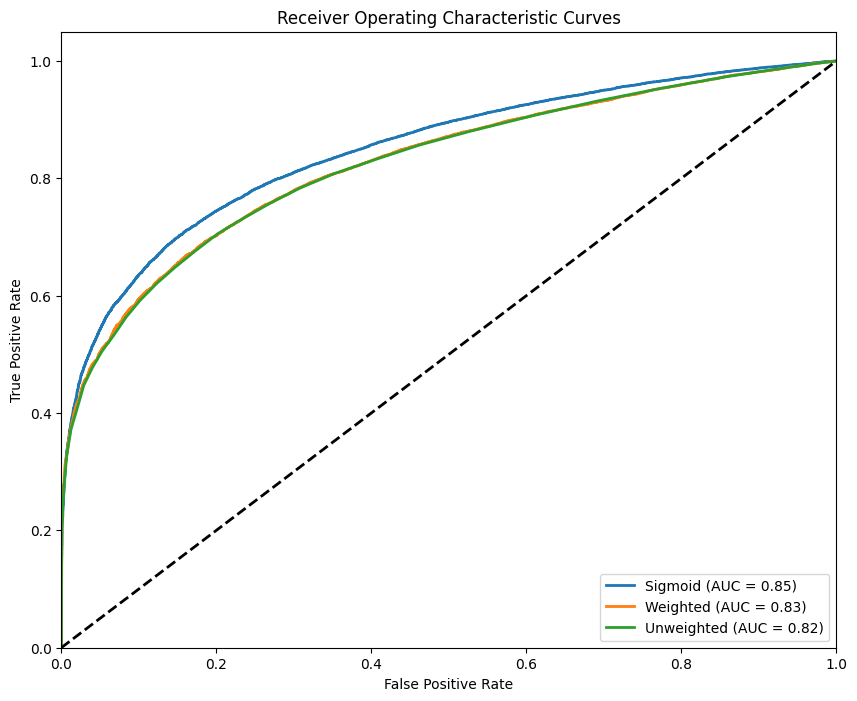

In [109]:
def plot_roc_curve(y_true, model_scores, model_labels):
    plt.figure(figsize=(10, 8))
    for scores, label in zip(model_scores, model_labels):
        fpr, tpr, _ = roc_curve(y_true, scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=2, label=f'{label} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # plot the line of no skill
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curves')
    plt.legend(loc="lower right")
    plt.savefig('ROC_curve.png', transparent=True)

    plt.show()

plot_roc_curve(y_true, [sigmoid_confidence, weighted_confidences, unweighted_confidences], ['Sigmoid', 'Weighted', 'Unweighted'])

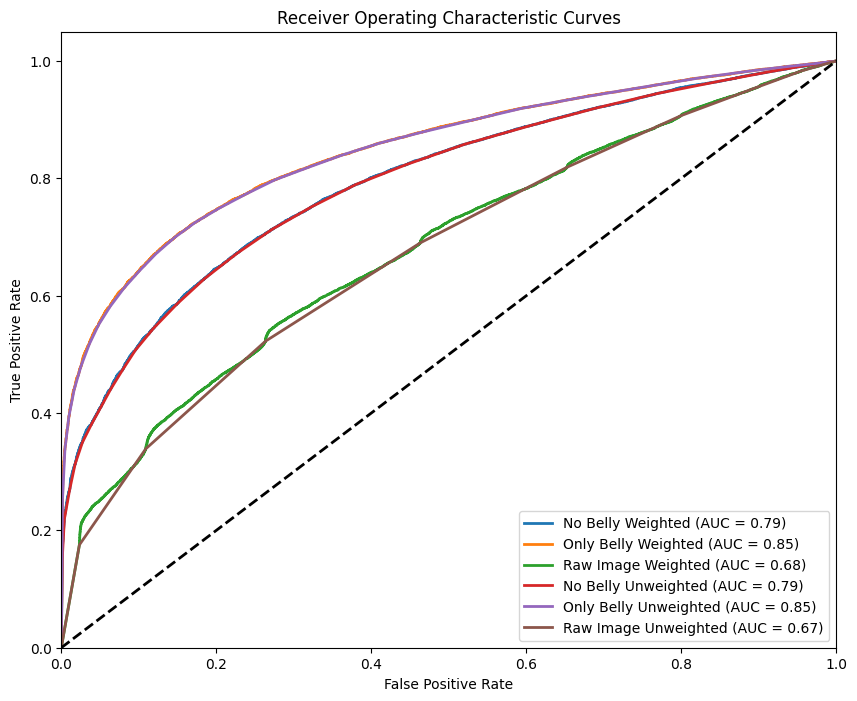

In [72]:
# ROC Curve for Iso-Tests
plot_roc_curve(y_true, [w_no_belly_test, w_belly_test, w_raw_test, uw_no_belly_test, uw_belly_test, uw_raw_test], ['No Belly Weighted', 'Only Belly Weighted', 'Raw Image Weighted', 'No Belly Unweighted', 'Only Belly Unweighted', 'Raw Image Unweighted'])

### 3.5 Sharpness

#### 3.5.1 Variance of confidence predictions
##### High variance ~ sharper forecasting

In [73]:
print("Model 1: Sigmoid Confidence Variance", np.var(sigmoid_confidence))
print("Model 2: Weighted Confidence Variance", np.var(weighted_confidences))
print("Model 2: Unweighted Confidence Variance", np.var(unweighted_confidences))

Model 1: Sigmoid Confidence Variance 0.08008537
Model 2: Weighted Confidence Variance 0.08191609167272428
Model 2: Unweighted Confidence Variance 0.08133822416561848


In [74]:
# Variance for Iso-Tests
print(f"No Belly W Variance:", np.var(w_no_belly_test))
print(f"Only Belly W Variance:", np.var(w_belly_test))
print(f"Raw Image W Variance:", np.var(w_raw_test))
print("\n")
print(f"No Belly UW Variance:", np.var(uw_no_belly_test))
print(f"Only Belly UW Variance:", np.var(uw_belly_test))
print(f"Raw Image UW Variance:", np.var(uw_raw_test))

No Belly W Variance: 0.06547600864354684
Only Belly W Variance: 0.09138766431006581
Raw Image W Variance: 0.004984996128020934


No Belly UW Variance: 0.0654364158907433
Only Belly UW Variance: 0.09124547875955555
Raw Image UW Variance: 0.004983105423681731


#### 3.5.2 Histogram of confidence predictions by method

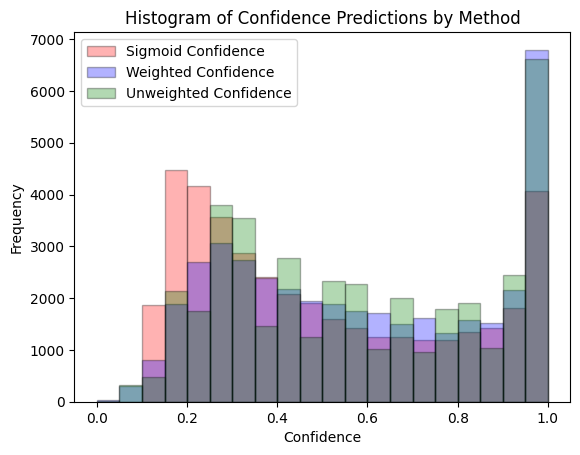

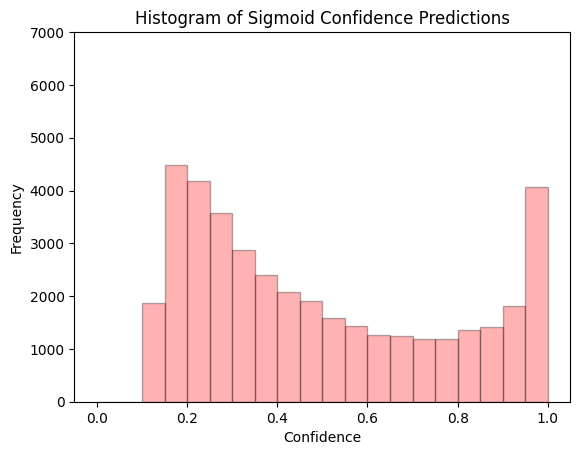

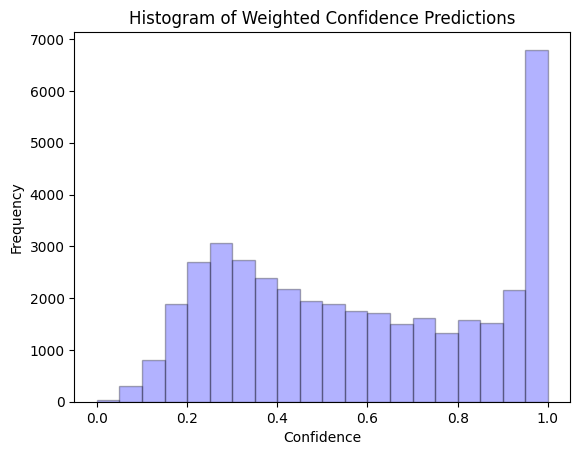

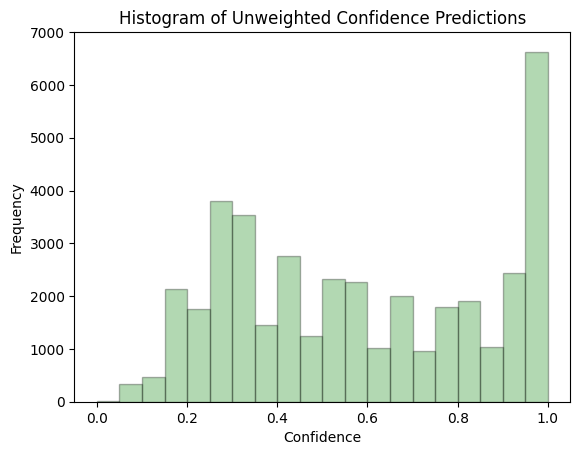

In [108]:
bin_edges = np.arange(0, 1.01, 0.05)
plt.hist(sigmoid_confidence, bins=bin_edges, alpha=0.3, label='Sigmoid Confidence', color='red', edgecolor='black')
plt.hist(weighted_confidences, bins=bin_edges, alpha=0.3, label='Weighted Confidence', color='blue', edgecolor='black')
plt.hist(unweighted_confidences, bins=bin_edges, alpha=0.3, label='Unweighted Confidence', color='green', edgecolor='black')

plt.title('Histogram of Confidence Predictions by Method')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.legend()

plt.show()

plt.hist(sigmoid_confidence, bins=bin_edges, alpha=0.3, label='Sigmoid Confidence', color='red', edgecolor='black')
plt.title('Histogram of Sigmoid Confidence Predictions')
plt.yticks(np.arange(0, 8000, 1000))
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.savefig('sigmoid_histogram.png', transparent=True)

plt.show()

plt.hist(weighted_confidences, bins=bin_edges, alpha=0.3, label='Weighted Confidence', color='blue', edgecolor='black')
plt.title('Histogram of Weighted Confidence Predictions')
plt.yticks(np.arange(0, 8000, 1000))
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.savefig('weighted_histogram.png', transparent=True)

plt.show()

plt.hist(unweighted_confidences, bins=bin_edges, alpha=0.3, label='Unweighted Confidence', color='green', edgecolor='black')
plt.title('Histogram of Unweighted Confidence Predictions')
plt.yticks(np.arange(0, 8000, 1000))
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.savefig('unweighted_histogram.png', transparent=True)

plt.show()

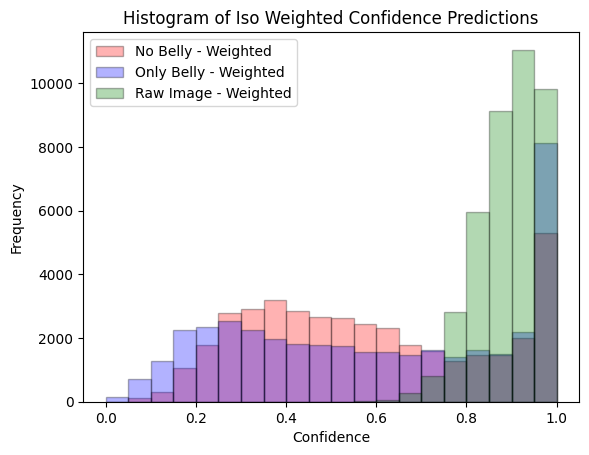

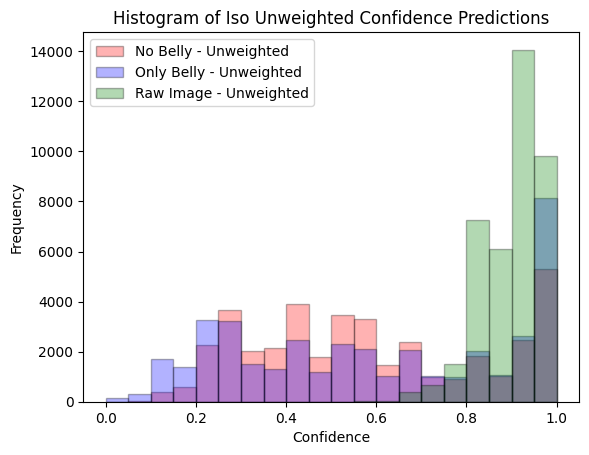

In [76]:
# Histogram for Iso-Tests
bin_edges = np.arange(0, 1.01, 0.05)
plt.hist(w_no_belly_test, bins=bin_edges, alpha=0.3, label='No Belly - Weighted', color='red', edgecolor='black')
plt.hist(w_belly_test, bins=bin_edges, alpha=0.3, label='Only Belly - Weighted', color='blue', edgecolor='black')
plt.hist(w_raw_test, bins=bin_edges, alpha=0.3, label='Raw Image - Weighted', color='green', edgecolor='black')

plt.title('Histogram of Iso Weighted Confidence Predictions')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.legend()

plt.show()


bin_edges = np.arange(0, 1.01, 0.05)
plt.hist(uw_no_belly_test, bins=bin_edges, alpha=0.3, label='No Belly - Unweighted', color='red', edgecolor='black')
plt.hist(uw_belly_test, bins=bin_edges, alpha=0.3, label='Only Belly - Unweighted', color='blue', edgecolor='black')
plt.hist(uw_raw_test, bins=bin_edges, alpha=0.3, label='Raw Image - Unweighted', color='green', edgecolor='black')

plt.title('Histogram of Iso Unweighted Confidence Predictions')
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.legend()

plt.show()

#### 3.5.3 Proportion of confidence predictions belonging to extreme threshold

In [77]:
extreme_thresholds = (0.1, 0.9)

def extreme_confidence(confidence, thresholds):
    confidence_array = np.array(confidence)
    return np.mean((confidence_array < thresholds[0]) | (confidence_array > thresholds[1]))

print("Proportion of Extreme Probabilities for Sigmoid Confidence: ", extreme_confidence(sigmoid_confidence, extreme_thresholds))
print("Proportion of Extreme Probabilities for Weighted Confidence: ", extreme_confidence(weighted_confidences, extreme_thresholds))
print("Proportion of Extreme Probabilities for Unweighted Confidence: ", extreme_confidence(unweighted_confidences, extreme_thresholds))

Proportion of Extreme Probabilities for Sigmoid Confidence:  0.14709273182957394
Proportion of Extreme Probabilities for Weighted Confidence:  0.23275689223057644
Proportion of Extreme Probabilities for Unweighted Confidence:  0.23568922305764411


In [78]:
print(f"No Belly W Extreme Probabilities:", {extreme_confidence(w_no_belly_test, extreme_thresholds)})
print(f"Only Belly W Extreme Probabilities:", {extreme_confidence(w_belly_test, extreme_thresholds)})
print(f"Raw Image W Extreme Probabilities:", {extreme_confidence(w_raw_test, extreme_thresholds)})
print("\n")
print(f"No Belly UW Extreme Probabilities:", {extreme_confidence(uw_no_belly_test, extreme_thresholds)})
print(f"Only Belly UW Extreme Probabilities:", {extreme_confidence(uw_belly_test, extreme_thresholds)})
print(f"Raw Image UW Extreme Probabilities:", {extreme_confidence(uw_raw_test, extreme_thresholds)})

No Belly W Extreme Probabilities: {0.18571428571428572}
Only Belly W Extreme Probabilities: {0.2807017543859649}
Raw Image W Extreme Probabilities: {0.5231077694235589}


No Belly UW Extreme Probabilities: {0.16659147869674185}
Only Belly UW Extreme Probabilities: {0.2507769423558897}
Raw Image UW Extreme Probabilities: {0.4180200501253133}


# 4. Demonstration

In [79]:
def demonstrate_sample(sample_index):
    sample_image = x_knn_test[sample_index]
    
    distances, indices = knn.kneighbors([x_test_encoded[sample_index]])
    confidence = get_confidence(1, indices, distances, is_weighted=False)[0]*100
    correctness = model_two_input_data.iloc[indices[0]]['correctness'].to_numpy()
    
    plt.imshow(sample_image)
    plt.title(f'Sample image - Confidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()
    
    fig, axs = plt.subplots(5, 6, layout='constrained')
    for i, ax in enumerate(axs.ravel()):
        ax.imshow(x_knn_train[indices[0][i]])
        
        # color outlines
        c = 'green' if correctness[i] == 1 else 'red'
        for spine in ax.spines.values():
            spine.set_edgecolor(c)
            spine.set_linewidth(2)
        
        # hide ticks
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        i += 1
        ax.set_title(str(i) + ('st' if i==1 else 'nd' if i==2 else 'rd' if i==3 else 'th'))
    fig.suptitle('Nearest Neighbors')
    plt.show()

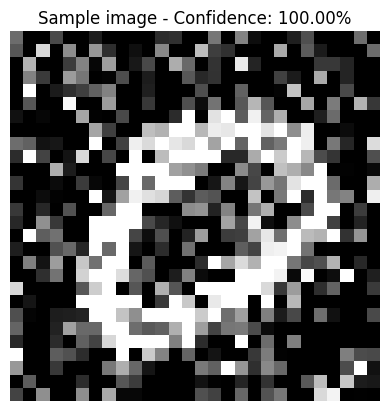

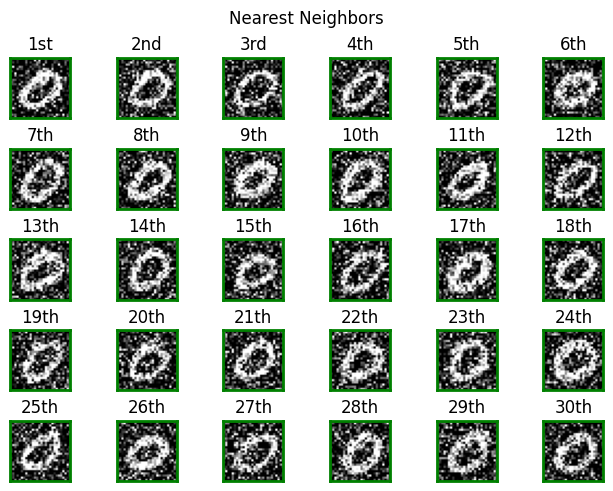

In [80]:
demonstrate_sample(6)

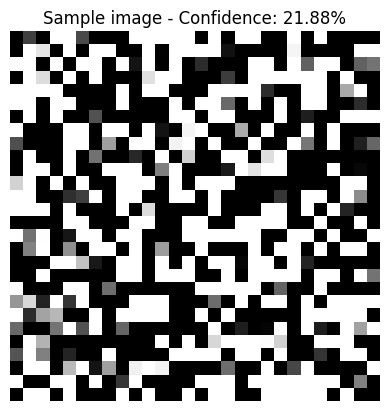

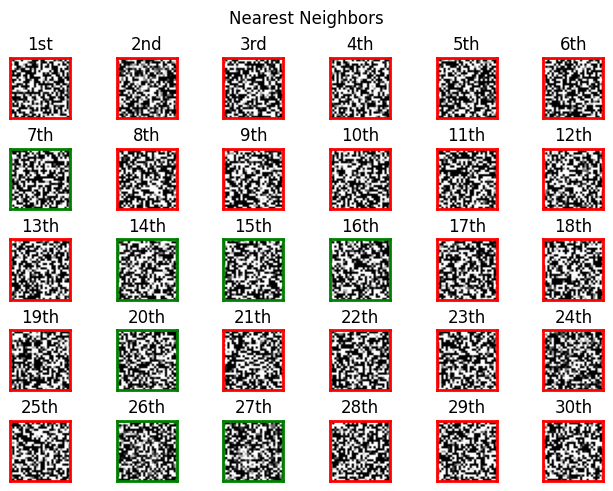

In [81]:
demonstrate_sample(2)

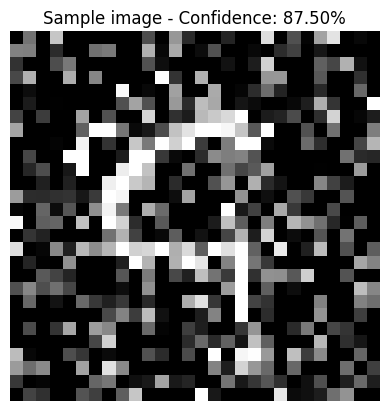

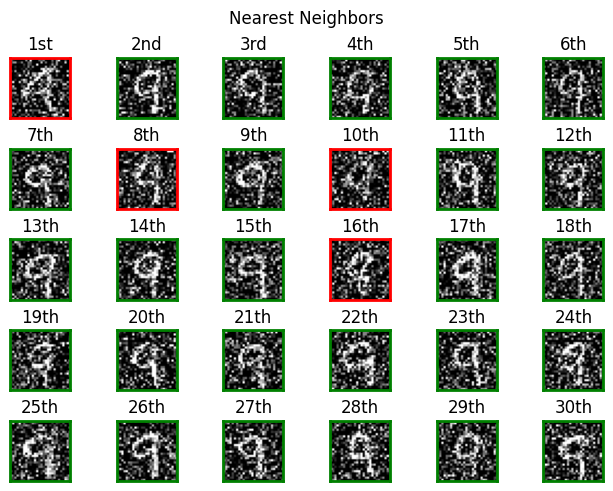

In [82]:
demonstrate_sample(14)